# Проведение АА-теста

**Загрузим из базы данные 2 и 3 экспериментальных групп за период с '2022-05-17' по '2022-05-23'**

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220620',
                      'user':'***', 
                      'password':'***'
                     }

q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-05-17' and '2022-05-23'
and exp_group in (2,3)
GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [2]:
df.groupby('exp_group', as_index=False)['user_id'].count()

,exp_group,user_id
0,2,8480
1,3,8569


Количество пользователей в группах отличается не значительно.  
Проверим нет ли пересечений между группами:

In [3]:
users_a = set(df[df['exp_group']==2]['user_id'])
users_b = set(df[df['exp_group']==3]['user_id'])
diff_vis = [x for x in users_a if x in users_b]
print('Количество пользователей, попавших в обе группы:', len(diff_vis))

Количество пользователей, попавших в обе группы: 0


**Проведем симуляцию 10000 АА-тестов**

In [4]:
# сохраним показатель ctr каждой группы в отдельные переменные
eg_2 = df[df['exp_group']==2]['ctr']
eg_3 = df[df['exp_group']==3]['ctr']

In [5]:
pvalues = []

for i in range(10000):
    p_value = stats.ttest_ind(np.random.choice(eg_2, 500, replace=True), # на каждой итерации сформируем подвыборки с повторением в 500 юзеров
                np.random.choice(eg_3, 500, replace=True),               # и сравненим эти подвыборки t-testом
                equal_var=False)[1]
    pvalues.append(p_value)                                              # получившиеся значения p_value будем сохранять в список

**Построим гистограмму распределения получившихся 10000 p-values**

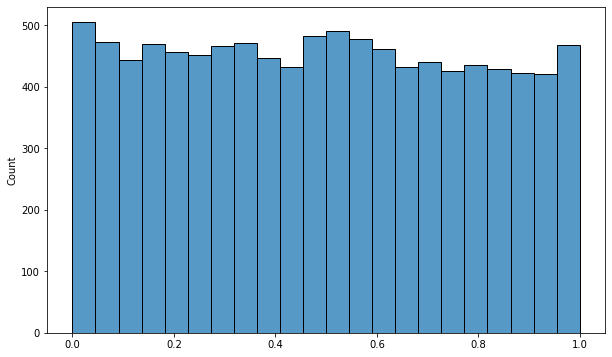

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(pvalues)
plt.show()

Равномерное распределение 

**Посчитаем, какой процент p values оказался меньше либо равен 0.05**

In [7]:
part = len(list(filter(lambda x: x <= 0.05, pvalues))) / len(pvalues)

In [8]:
print(f'В результате сравнения подвыборок t-testом в {part:.2%} случаев у нас получились статистически значимые различия между группами')

В результате сравнения подвыборок t-testом в 5.48% случаев у нас получились статистически значимые различия между группами


**Вывод по АА-тесту:**

Полученный результат позволяет нам сделать вывод о том, что наша система сплитования работает корректно. Из 10000 тестов приблизительно в 5% случаев мы получали значимые различия.